In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import pyro

from src.data.preprocessing import load_thickness_time_series
from src.models.paths import PROJECT_ROOT
from src.models.solid_earth_utils import compute_love_numbers, greens_function

print(PROJECT_ROOT)

/mnt/c/Users/dnjllg/OneDrive - Danmarks Tekniske Universitet/Dokumenter/PhD/Courses/Model-based Machine Learning/premis


In [68]:
from torch.distributions import constraints
from torch.distributions.transforms import AbsTransform

from pyro.distributions.torch import TransformedDistribution
from torch.distributions.transforms import Transform 

class IntervalTransform(Transform):
    r"""
    Transform via the mapping :math:`y = a <= x <= b`.
    """
    domain = constraints.real
    codomain = constraints.positive
    def __init__(self, a, b, event_dim=0, cache_size=0):
        self.a = a
        self.b = b
        self._event_dim = event_dim
        self._cache_size = cache_size
        
    def __eq__(self, other):
        return isinstance(other, IntervalTransform(self.a, self.b))

    def _call(self, x):
        x[self.a > x] = self.a
        x[self.b < x] = self.b
        return x

    def _inverse(self, y):
        return y

class IntervalFoldedDistribution(TransformedDistribution):
    """
    Equivalent to ``TransformedDistribution(base_dist, AbsTransform())``,
    but additionally supports :meth:`log_prob` .

    :param ~torch.distributions.Distribution base_dist: The distribution to
        reflect.
    """

    support = constraints.positive

    def __init__(self, base_dist, validate_args=None, lower=8e3, upper=1.4e4):
        if base_dist.event_shape:
            raise ValueError("Only univariate distributions can be folded.")
        super().__init__(base_dist, IntervalTransform(a=lower, b=upper), validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(type(self), _instance)
        return super().expand(batch_shape, _instance=new)


    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        dim = max(len(self.batch_shape), value.dim())
        plus_minus = value.new_tensor([1.0, -1.0]).reshape((2,) + (1,) * dim)
        return self.base_dist.log_prob(plus_minus * value).logsumexp(0)

In [69]:
from torch.distributions import constraints
from torch.distributions.transforms import AbsTransform

from pyro.distributions.torch import TransformedDistribution
from torch.distributions.transforms import Transform 

class IntervalTransform(Transform):
    r"""
    Transform via the mapping :math:`y = a <= x <= b`.
    """
    domain = constraints.real
    codomain = constraints.positive
    def __init__(self, a, b, event_dim=0, cache_size=0):
        self.a = a
        self.b = b
        self._event_dim = event_dim
        self._cache_size = cache_size
        
    def __eq__(self, other):
        return isinstance(other, IntervalTransform(self.a, self.b))

    def _call(self, x):
        x[self.a > x] = self.a
        x[self.b < x] = self.b
        return x

    def _inverse(self, y):
        return y

class IntervalFoldedDistribution(TransformedDistribution):
    """
    Equivalent to ``TransformedDistribution(base_dist, AbsTransform())``,
    but additionally supports :meth:`log_prob` .

    :param ~torch.distributions.Distribution base_dist: The distribution to
        reflect.
    """

    support = constraints.positive

    def __init__(self, base_dist, validate_args=None, lower=8e3, upper=1.4e4):
        if base_dist.event_shape:
            raise ValueError("Only univariate distributions can be folded.")
        super().__init__(base_dist, IntervalTransform(a=lower, b=upper), validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(type(self), _instance)
        return super().expand(batch_shape, _instance=new)


    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        dim = max(len(self.batch_shape), value.dim())
        plus_minus = value.new_tensor([1.0, -1.0]).reshape((2,) + (1,) * dim)
        return self.base_dist.log_prob(plus_minus * value).logsumexp(0)

In [160]:
Nr = np.arange(1, 6).tolist()
radius = [6371e3, 6301e3, 5951e3, 5701e3, 3480e3]
density = [3.037e3, 3.438e3, 3.871e3, 4.978e3, 10.750e3]
rigidity = [0.50605e11, 0.70363e11, 1.05490e11, 2.28340e11, 0.0000e11]
bulk = [5.7437e10, 9.9633e10, 1.5352e11, 3.2210e11, 1.1018e12]
viscosity = [1.0e55, 1.0e21, 1.0e21, 2.0e21, 0.0e21]

df_em = pd.DataFrame(
    np.array([Nr, radius, density, rigidity, bulk, viscosity]).T,
    columns=["Nr", "radius", "density", "rigidity", "bulk", "viscosity"],
)

lmax = 256
lmin = 0
lstep = 1
CONF = {
    "EARTH_FILE": "earth_M3L70V01c.txt",
    "COMPRESS": "1",
    "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
    "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
}

df_kuaq = pd.read_csv(PROJECT_ROOT / "data" / "processed" / "KUAQ_filtered.csv")
df_kuaq.Time = pd.to_datetime(df_kuaq.Time)
df_alti = pd.read_csv(PROJECT_ROOT / "data" / "raw" / "kauq_altimetry.csv")
df_alti.time = pd.to_datetime(df_alti.time)
# df_mass = pd.read_csv(PROJECT_ROOT / "data" / "processed" / "mass_time_series.csv")
df_height = load_thickness_time_series(
    PROJECT_ROOT / "data" / "processed" / "1900_2020_mean_thickness.mat"
)
df = pd.merge(df_height, df_kuaq, how="inner")

height = df.Thickness.values
uplift = df.Up.values

df_em

,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+55
1,2.0,6301000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
2,3.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
3,4.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
4,5.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


In [161]:
#df_alti.shift(periods=2)
df_alti.index = df_alti.time

In [165]:
df_alti = df_alti.shift(periods=2)

In [166]:
df_alti

,time,dh,dhdt
time,,,
1992-01-01,NaT,NaN,NaN
1992-02-01,NaT,NaN,NaN
1992-03-01,1992-01-01,0.000000,0.008487
1992-04-01,1992-02-01,0.069833,0.837995
1992-05-01,1992-03-01,0.340605,3.249268
...,...,...,...
2020-03-01,2020-01-01,-10.202380,-0.442787
2020-04-01,2020-02-01,-10.320489,-1.417297
2020-05-01,2020-03-01,-10.488174,-2.012232


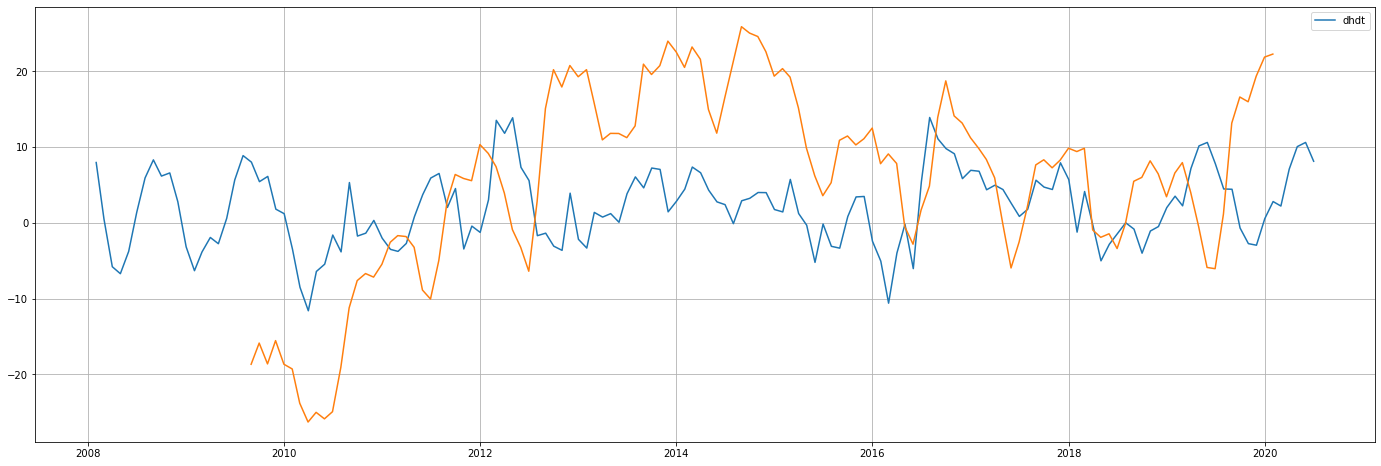

In [167]:

#df_alti.dhdt.plot()
fig, ax = plt.subplots(1, 1, figsize=(24, 8))
plt.plot(df_alti.index[-150:], -df_alti.dhdt[-150:]*5, label="dhdt")
plt.plot(df.Time,df.Up - np.arange(len(df.Up))*1.3+100)
plt.grid()
plt.legend()

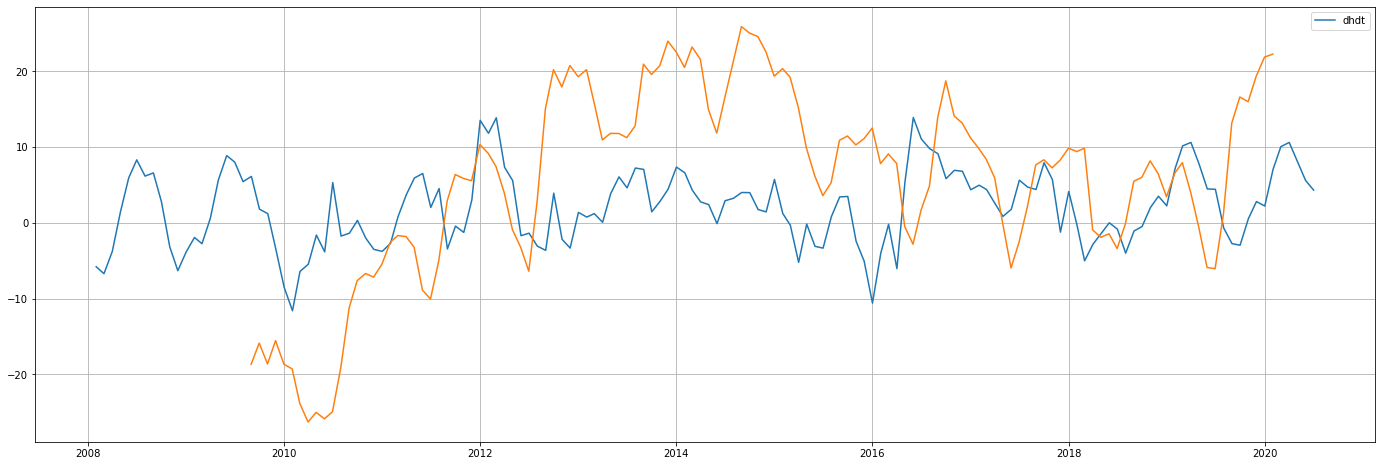

In [159]:


#df_alti.dhdt.plot()
fig, ax = plt.subplots(1, 1, figsize=(24, 8))
plt.plot(df_alti.index[-150:], -df_alti.dhdt[-150:]*5, label="dhdt")
plt.plot(df.Time,df.Up - np.arange(len(df.Up))*1.3+100)
plt.grid()
plt.legend()

In [71]:
from datetime import datetime, timedelta, date

def year_convert(df: pd.DataFrame) -> pd.DataFrame:
    '''Convert dataframe year with xxxx.xx format to datetime yyyy-mm-dd'''
    Year_datetime = pd.to_datetime(df.Time)
    for idx, Year in enumerate(df.Time):
        start = Year
        year = int(start)
        rem = start - year

        base = datetime(year, 1, 1)
        result = base + timedelta(
            seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem
        )
        Year_datetime[idx] = result

    Year_datetime = Year_datetime.dt.floor("D")
    df.Time = Year_datetime
    df = df[~df.Time.duplicated()]
    df.index = df.Time
    df = df.drop('Time', axis=1)
    df = df.asfreq('D')

    return df

In [83]:
from scipy.io import loadmat
mat_file = PROJECT_ROOT / "data" / "processed" / "1900_2020_mean_thickness.mat"
mat = loadmat(mat_file)

time = mat['time'].squeeze()
thickness = mat['thickness'].squeeze()

d = {'Time': time, 'Thickness': thickness}
df = pd.DataFrame(data=d)
#df = df.diff() # running change
df = df.dropna()
df = year_convert(df)

"""
df_desc = df.groupby(pd.Grouper(level="Time", freq="W"))[
    ["Thickness"]
].describe()

d = {'Time': df_desc.index, 'Thickness': df_desc.iloc[:, 1].values}
df = pd.DataFrame(data=d)
df = df.interpolate('pad')
d
"""

'\ndf_desc = df.groupby(pd.Grouper(level="Time", freq="W"))[\n    ["Thickness"]\n].describe()\n\nd = {\'Time\': df_desc.index, \'Thickness\': df_desc.iloc[:, 1].values}\ndf = pd.DataFrame(data=d)\ndf = df.interpolate(\'pad\')\nd\n'

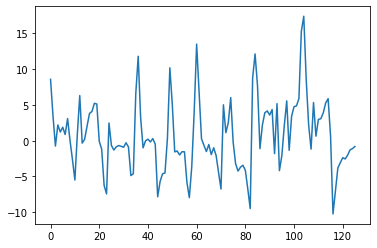

In [29]:
hlove, nlove = compute_love_numbers(df_em=df_em, CONF=None, verbose=0)
gf = greens_function(hlove, nlove, [68.704665, -33.214577], [68.58700000, -33.05270000], arsurf=250e3*250e3)

plt.plot(gf * height)

In [66]:
140*140


19600

In [6]:
def model(height, obs=None, df_em=None):
    N = len(height)
    X = torch.arange(N)
    alpha = pyro.sample("alpha",dist.Normal(-100,10))
    beta = pyro.sample("beta", dist.Normal(1,1))
    sigma_w = 1 #pyro.sample("sigma", dist.HalfCauchy(0.1))
    
    # rigidity layer 1
    loc, scale = 2, 0.5
    rigidity_dist_1 = IntervalFoldedDistribution(dist.Normal(loc, scale), lower=loc * 1e-2, upper=loc * 1e2)
    rigidity_1 = 1e10 * pyro.sample("rigidity_1", rigidity_dist_1)
        
    # rigidity layer 2
    # rigidity_dist_2 = dist.Normal(1, 0.2)
    # rigidity_2 = 1e10 * pyro.sample("rigidity_2", rigidity_dist_2)    
    
    # dictionary = {"sample": sample1}
    df_em["rigidity"][0] = rigidity_1.item()

    # Draw Love Numbers
    hlove, nlove = compute_love_numbers(df_em=df_em, CONF=None, verbose=0)
    
    # Draw Greens Function
    gf = greens_function(hlove, nlove, [68.704665, -33.214577], [68.58700000, -33.05270000], arsurf=30e3*30e3)

    # Draw target
    w = pyro.sample("w", dist.Normal(alpha + X * beta + gf * height, sigma_w), obs=obs)
    
    return w

In [7]:
X_train = torch.tensor(height).float()
y_train = torch.tensor(uplift).float()

In [8]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=50, warmup_steps=5, num_chains=1)
mcmc.run(X_train, y_train, df_em)

# Show summary of inference results
mcmc.summary()

Sample: 100%|████| 55/55 [07:00,  7.65s/it, step size=1.57e-03, acc. prob=0.865]


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       alpha     -1.65      0.56     -1.50     -2.36     -0.98      2.67      2.31
        beta      0.23      0.01      0.23      0.22      0.24      2.81      2.05
  rigidity_1      2.53      0.05      2.53      2.46      2.59      3.42      1.46

Number of divergences: 0


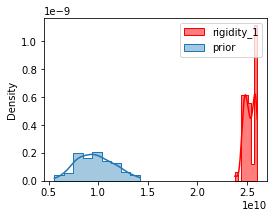

In [9]:
samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["rigidity_1"]

rigidity_dist_prior = dist.Normal(torch.ones(150), 0.2)
rigidity_prior = 1e10 * pyro.sample("rigidity_prior", rigidity_dist_prior)

for node in nodes:
    plt.figure(figsize=(4,3))
    sns.histplot(samples[node]*1e10, label=node, kde=True, stat='density', element="step", color="red")
    sns.histplot(rigidity_prior, label="prior", kde=True, stat='density', element="step", alpha=0.4)
    plt.legend()
    plt.show()

In [10]:
df_em

,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,2.378261e+10,5.743700e+10,1.000000e+55
1,2.0,6301000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
2,3.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
3,4.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
4,5.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


In [11]:
N = len(height)
X = torch.arange(N)



In [17]:
posterior_samples = mcmc.get_samples()

alpha_hat = mcmc.get_samples(1)["alpha"]
beta_hat = mcmc.get_samples(1)["beta"]
rigidity_hat = mcmc.get_samples(1)["rigidity_1"]

beta_hat

tensor([0.2365])

In [18]:
df_em["rigidity"][0] = rigidity_hat.item() * 1e10
hlove, nlove = compute_love_numbers(df_em=df_em, CONF=None, verbose=0)
gf = greens_function(hlove, nlove, [68.704665, -33.214577], [68.58700000, -33.05270000])

In [19]:
alpha_hat

tensor([-1.2266])

In [20]:
y_hat = alpha_hat + X * beta_hat + gf * height

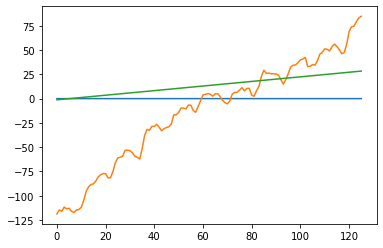

In [21]:
plt.plot(gf * height)
plt.plot(uplift)
plt.plot(y_hat)

## Different things from earlier work

In [ ]:
dont run the next cells

In [ ]:
class TruncatedNormal(dist.Rejector):
    def __init__(self, loc, scale_0, max_x0):
        propose = dist.Normal(loc, scale_0)

        def log_prob_accept(x):
            return (x[0] < max_x0).type_as(x).log()

        log_scale = torch.tensor(dist.LogNormal(loc, scale_0).cdf(max_x0)).log()
        super(TruncatedLogNormal, self).__init__(propose, log_prob_accept, log_scale)

In [ ]:
## TODO: For guide support, see: https://forum.pyro.ai/t/truncated-log-normal-distribution/2002
# from torch.distributions import constraints

# class TruncatedLogNormal(dist.Rejector):
#     ...
#     @constraints.dependent_property
#     def support(self):
#         return constraints.interval(0, self.max_x0)

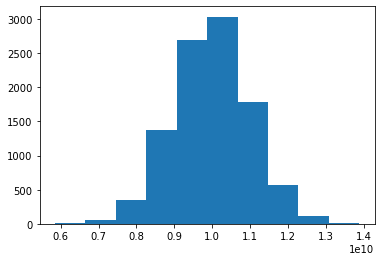

In [ ]:
diste = IntervalFoldedDistribution(dist.Normal(1e10*torch.ones(10000), 1e9), lower=1e8, upper=1e12)
plt.hist(np.array(pyro.sample("test", diste)));

tensor(0.)

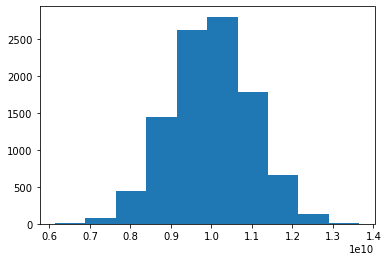

In [ ]:
samples = 1e10 * pyro.sample("test", dist.Normal(torch.ones(10000), 0.1))
plt.hist(np.array(samples));
samples[samples < 1e8].sum()

In [208]:
import numpyro
import numpyro.distributions as np_dist
from numpyro.infer import MCMC, NUTS

def model():

    # sample1 = numpyro.sample("rigidity1", bounded_rig1)
    rigidity_unscaled = numpyro.sample("rigidity_unscaled", np_dist.Normal(0, 1))
    
    rigidity_scaled = numpyro.deterministic("rigidity_scaled", 1e10 + 1e9 * rigidity_unscaled)
    # rigidity_scaled = numpyro.sample("rigidity_scaled", np_dist.Uniform(1e9, 1e11))

    
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
num_samples = 10000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(rng_key_)

print(mcmc.get_samples()["rigidity_scaled"].min() , mcmc.get_samples()["rigidity_scaled"].mean(), mcmc.get_samples()["rigidity_scaled"].max())

sample: 100%|██████████| 11000/11000 [00:14<00:00, 774.53it/s, 3 steps of size 1.26e+00. acc. prob=0.89]


-3806359800.0 -24906074.0 4083562800.0


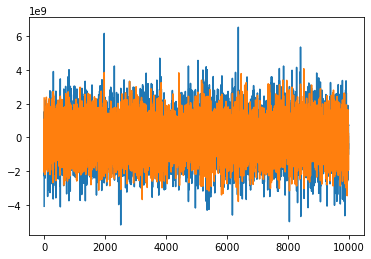

In [209]:
samples = mcmc.get_samples()["rigidity_scaled"].to_py()
plt.plot(np.diff(samples))
plt.plot(samples)

In [166]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

def model(height, obs=None, df_em=None):
    sample1 = pyro.sample("rigidity1", dist.Normal(1, 1e-1))

# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1, num_chains=1)
mcmc.run(X_train, y_train, df_em)

print(mcmc.get_samples()["rigidity1"].min() , mcmc.get_samples()["rigidity1"].mean(), mcmc.get_samples()["rigidity1"].max())

Sample: 100%|██████████| 1001/1001 [12:24,  1.34it/s, step size=1.16e-10, acc. prob=1.000]

tensor(0.8238) tensor(0.9997) tensor(1.)
